In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import numpy as np
import numpy.linalg as LA

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
import time
from datetime import datetime

from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score, cross_validate 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from statistics import mean

import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.tools.eval_measures import mse, rmse, meanabs, stde
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.seasonal import seasonal_decompose

from dateutil.parser import parse

from scipy.stats import pearsonr, spearmanr, kendalltau, poisson, bernoulli

In [28]:
url = "/content/drive/Shareddrives/Ciencia de datos y asi/Data/2012_2019_PlatteRiverWeir_features_merged_all.csv"
df = pd.read_csv(url)
df.head(3)

,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,width,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
x = pd.to_datetime(df[' CaptureTime'], format="%Y-%m-%d %H:%M:%S")

time = []
for day in x:
  time.append(day.timestamp())
  
df["CaptureTimeSeconds"] = time
df["datetime"] = x

In [30]:
df_train = df[df['datetime'].dt.year < 2018].reset_index().copy()

In [31]:
df_test = df[df['datetime'].dt.year >= 2018].reset_index().copy()

## Data Analysis

### Variables

In [32]:
scaler = StandardScaler()

In [33]:
X_train = df_train[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
y_train = df_train[ ' Stage']

X_test = df_test[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
y_test = df_test[ ' Stage']

scaled_Xtrain = scaler.fit_transform(X_train)
scaled_Xtest = scaler.fit_transform(X_test)
#scaled_y = scaler.fit_transform(y)

X_train = pd.DataFrame(scaled_Xtrain, columns=X_train.columns)
#X_train = sm.add_constant(X_train)

X_test = pd.DataFrame(scaled_Xtest, columns=X_test.columns)
#X_test = sm.add_constant(X_test)
#y = pd.DataFrame(scaled_y, index=df.index, columns=y.columns)

### Correlation

In [34]:
df = pd.concat([X_train, y_train], axis=1)
df.corr()

,width,height,exposure,grayMean,graySigma,entropyMean,entropySigma,hMean,hSigma,sMean,...,WeirPt1Y,WeirPt2X,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma,Stage
width,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exposure,NaN,NaN,1.000000,-0.320208,-0.106138,-0.294322,-0.284018,-0.310524,-0.067397,0.450923,...,0.044727,0.043949,-0.026981,-0.074080,-0.078651,-0.070298,-0.068056,-0.078385,-0.071857,-0.079008
grayMean,NaN,NaN,-0.320208,1.000000,-0.393259,0.613793,0.596126,0.997488,-0.445410,-0.183380,...,-0.066787,-0.051934,-0.007713,0.134464,0.071748,0.108933,0.126413,0.069318,0.101324,-0.213171
graySigma,NaN,NaN,-0.106138,-0.393259,1.000000,-0.239273,-0.194675,-0.445605,0.996003,0.023464,...,0.002789,-0.011061,-0.043921,-0.196033,-0.146378,-0.185031,-0.200779,-0.147765,-0.185363,0.013910
entropyMean,NaN,NaN,-0.294322,0.613793,-0.239273,1.000000,0.991398,0.618453,-0.264800,-0.211154,...,0.076288,0.085548,-0.018572,0.198516,0.089050,0.167608,0.181537,0.089314,0.153649,-0.325786
entropySigma,NaN,NaN,-0.284018,0.596126,-0.194675,0.991398,1.000000,0.598501,-0.217169,-0.195867,...,0.068587,0.078822,-0.027753,0.176391,0.062723,0.146665,0.158546,0.062688,0.131603,-0.335188
hMean,NaN,NaN,-0.310524,0.997488,-0.445605,0.618453,0.598501,1.000000,-0.495998,-0.197688,...,-0.067841,-0.052330,-0.001322,0.149070,0.085361,0.124654,0.141748,0.083134,0.117727,-0.195975
hSigma,NaN,NaN,-0.067397,-0.445410,0.996003,-0.264800,-0.217169,-0.495998,1.000000,0.057762,...,0.000307,-0.014496,-0.044137,-0.207232,-0.155897,-0.195151,-0.211001,-0.157283,-0.195077,0.014759
sMean,NaN,NaN,0.450923,-0.183380,0.023464,-0.211154,-0.195867,-0.197688,0.057762,1.000000,...,0.013750,0.010430,-0.137210,-0.253913,-0.281634,-0.273966,-0.256441,-0.282339,-0.288901,-0.412445


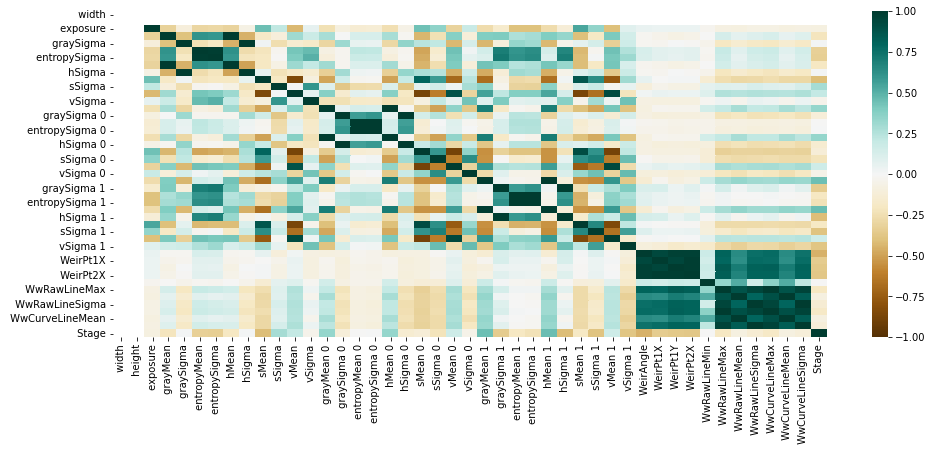

In [35]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='BrBG')

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Text(0.5, 1.0, 'Spearman correlation')

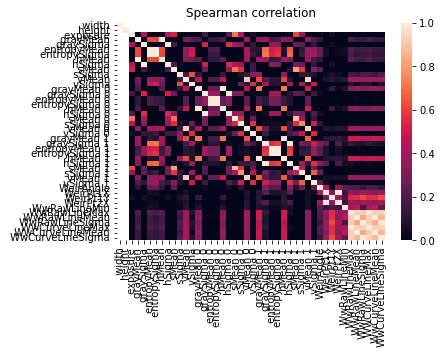

In [36]:
nvar = X_train.columns.size
corr = X_train.corr()
cov = X_train.cov(ddof=1)

rho_pval = np.zeros((nvar, nvar))
rho = np.eye(nvar)

for i in range(nvar):
    for j in range(i+1, nvar):
        r = spearmanr(X_train.iloc[:, i], X_train.iloc[:, j])
        rho[i, j] = r[0]
        rho[j, i] = r[0]
        
        rho_pval[i, j] = r[1]
        rho_pval[j, i] = r[1]

sns.heatmap(rho, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)
plt.title("Spearman correlation")

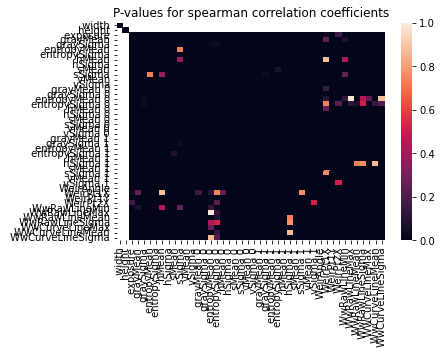

In [37]:
plt.title("P-values for spearman correlation coefficients")
sns.heatmap(rho_pval, xticklabels=corr.columns, yticklabels=corr.columns, vmin=0, vmax=1)

In [38]:
det = LA.det(cov)
det

0.0

### PCA

In [39]:
pca = PCA(n_components = nvar)
pca.fit(X_train)

PCA(n_components=44)

Varianza explicada acumulada:
 [0.27802931 0.45589612 0.59631991 0.69249894 0.75541449 0.79918572
 0.83288104 0.85977135 0.88146397 0.8996249  0.91357449 0.92651162
 0.93834999 0.94973869 0.95918877 0.96669573 0.97309259 0.97804614
 0.98250623 0.98656924 0.99060362 0.99335036 0.99518576 0.99647735
 0.99755742 0.99835191 0.99893224 0.99928841 0.99958941 0.99970095
 0.99978498 0.99985002 0.99989436 0.99992642 0.99994728 0.99996425
 0.99997944 0.99998997 0.99999431 0.9999984  0.99999999 1.
 1.         1.        ]


Text(0.5, 1.0, 'Número de componentes vs porcentaje de varianza explicada')

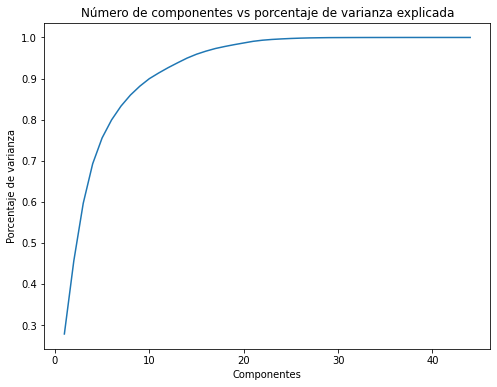

In [40]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

print("Varianza explicada acumulada:\n", cumulative_variance)

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 45, 1), cumulative_variance)
plt.xlabel("Componentes")
plt.ylabel("Porcentaje de varianza")
plt.title("Número de componentes vs porcentaje de varianza explicada")

## Models

In [41]:
print('min', min(df[' Stage']))
print('max', max(df[' Stage']))
print('mean', mean(df[' Stage']))

min 0.0
max 6.49
mean 2.9544715560029156


### Linear Regression

In [42]:
modeLr = LinearRegression()
resLr = modeLr.fit(X_train, y_train)

In [43]:
y_pred = resLr.predict(X_test)
res = y_test.squeeze() - y_pred.squeeze()

print("MSE: ", mse(y_test.squeeze(), y_pred))
print("RSMSE: ", rmse(y_test.squeeze(), y_pred))
print("MAE: ", meanabs(y_test.squeeze(), y_pred))
print("Error estandar: ", stde(y_test.squeeze(), y_pred, ddof = 3))

MSE:  0.7845702963832517
RSMSE:  0.8857597283593626
MAE:  0.5379989235342952
Error estandar:  0.8526042696017818


### Ridge Regression

In [44]:
ridgeMod = Ridge(alpha=1.0)
resRid = ridgeMod.fit(X_train, y_train)

In [45]:
y_pred = resRid.predict(X_test)
res = y_test.squeeze() - y_pred.squeeze()

print("MSE: ", mse(y_test.squeeze(), y_pred))
print("RSMSE: ", rmse(y_test.squeeze(), y_pred))
print("MAE: ", meanabs(y_test.squeeze(), y_pred))
print("Error estandar: ", stde(y_test.squeeze(), y_pred, ddof = 3))

MSE:  0.24556144521940268
RSMSE:  0.4955415675999367
MAE:  0.363681173378327
Error estandar:  0.433362554415278


Text(0.5, 0, 'Ridge Regression Feature Importance')

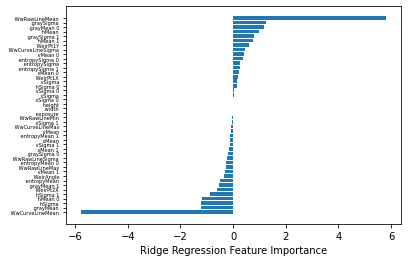

In [46]:
sorted_idx = resRid.coef_.argsort()
plt.barh(X_train.columns[sorted_idx], resRid.coef_[sorted_idx])
plt.yticks(fontsize=5)
plt.xlabel("Ridge Regression Feature Importance")

In [47]:
X_train.columns[sorted_idx]

Index([' WwCurveLineMean', ' grayMean', ' hSigma', ' hMean 0', ' hSigma 1',
       ' WeirPt2X', ' grayMean 1', ' entropyMean', ' WeirAngle', ' vMean 1',
       ' WwRawLineMax', ' entropyMean 0', ' WwRawLineSigma', ' graySigma 0',
       ' sMean 1', ' vSigma 1', ' sMean', ' entropyMean 1', ' vMean',
       ' WwCurveLineMax', ' sSigma 1', ' WwRawLineMin', ' exposure', ' width',
       ' height', ' sSigma 0', ' sSigma', ' vSigma 0', ' hSigma 0', ' vSigma',
       ' WeirPt1X', ' sMean 0', ' entropySigma 1', ' entropySigma',
       ' entropySigma 0', ' vMean 0', ' WwCurveLineSigma', ' WeirPt1Y',
       ' hMean 1', ' graySigma 1', ' hMean', ' grayMean 0', ' graySigma',
       ' WwRawLineMean'],
      dtype='object')

### Lasso Regression

In [48]:
lassoMod = Lasso(alpha=1.0)
resLasso = lassoMod.fit(X_train, y_train)

In [49]:
y_pred = resLasso.predict(X_test)
res = y_test.squeeze() - y_pred.squeeze()

print("MSE: ", mse(y_test.squeeze(), y_pred))
print("RSMSE: ", rmse(y_test.squeeze(), y_pred))
print("MAE: ", meanabs(y_test.squeeze(), y_pred))
print("Error estandar: ", stde(y_test.squeeze(), y_pred, ddof = 3))

MSE:  0.4435528117190403
RSMSE:  0.6659976063913746
MAE:  0.5997875209783836
Error estandar:  0.6211596535719283


### Knn

In [50]:
error = []

for i in range(1,100):
 kNN = KNeighborsRegressor(n_neighbors=i, metric='euclidean')
 kNN.fit(X_train, y_train)
 ypred = kNN.predict(X_test)
 error.append(meanabs(y_test, ypred))

k = np.array(error).argmin() + 1
print("Minimum error:",min(error))
print("k = ", k)

Minimum error: 0.25929218426501033
k =  7


Text(0, 0.5, 'Mean Absolute Error')

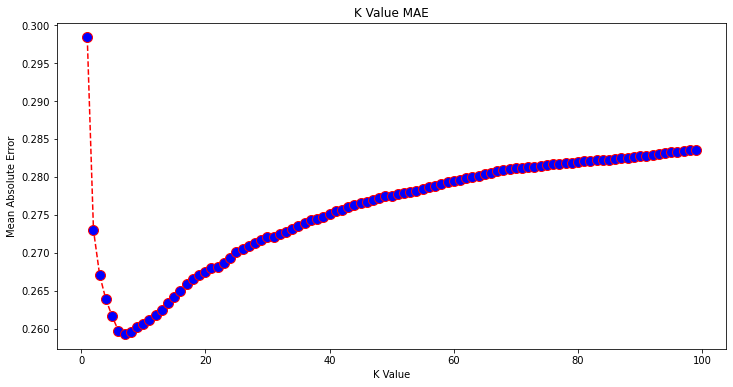

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 100), error, color='red', 
         linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
         
plt.title('K Value MAE')
plt.xlabel('K Value')
plt.ylabel('Mean Absolute Error')

In [52]:
kMod = KNeighborsRegressor(n_neighbors=75)
resK = kMod.fit(X_train, y_train)

In [53]:
y_pred = resK.predict(X_test)
res = y_test.squeeze() - y_pred.squeeze()

print("MSE: ", mse(y_test.squeeze(), y_pred))
print("RSMSE: ", rmse(y_test.squeeze(), y_pred))
print("MAE: ", meanabs(y_test.squeeze(), y_pred))
print("Error estandar: ", stde(y_test.squeeze(), y_pred, ddof = 3))

MSE:  0.19566358537707995
RSMSE:  0.4423387676623879
MAE:  0.2815643820450886
Error estandar:  0.40670243654188376


### Decision Tree

In [54]:
dTreeMod = DecisionTreeRegressor(random_state=0)
resTree = dTreeMod.fit(X_train, y_train)

In [55]:
y_pred = resTree.predict(X_test)
res = y_test.squeeze() - y_pred.squeeze()

print("MSE: ", mse(y_test.squeeze(), y_pred))
print("RSMSE: ", rmse(y_test.squeeze(), y_pred))
print("MAE: ", meanabs(y_test.squeeze(), y_pred))
print("Error estandar: ", stde(y_test.squeeze(), y_pred, ddof = 3))

MSE:  0.39817512832125607
RSMSE:  0.6310111950839351
MAE:  0.3887462258454107
Error estandar:  0.6130199851708293


### Random Forest

In [56]:
rForMod = RandomForestRegressor()
rForRes = rForMod.fit(X_train, y_train)

In [57]:
y_pred = resTree.predict(X_test)
res = y_test.squeeze() - y_pred.squeeze()

print("MSE: ", mse(y_test.squeeze(), y_pred))
print("RSMSE: ", rmse(y_test.squeeze(), y_pred))
print("MAE: ", meanabs(y_test.squeeze(), y_pred))
print("Error estandar: ", stde(y_test.squeeze(), y_pred, ddof = 3))

MSE:  0.39817512832125607
RSMSE:  0.6310111950839351
MAE:  0.3887462258454107
Error estandar:  0.6130199851708293


## Ridge Regression with Seasons extrapolation (2018-2019)  

In [58]:
spring = df_test[((df_test['datetime'].dt.day >= 21) & (df_test['datetime'].dt.month == 3)) | ((df_test['datetime'].dt.month >= 4) & (df_test['datetime'].dt.month <= 5)) | ((df_test['datetime'].dt.day <= 20) & (df_test['datetime'].dt.month == 6))]
spring_idx = spring.index

summer = df_test[((df_test['datetime'].dt.day >= 21) & (df_test['datetime'].dt.month == 6)) | ((df_test['datetime'].dt.month >= 7) & (df_test['datetime'].dt.month <= 8)) | ((df_test['datetime'].dt.day <= 22) & (df_test['datetime'].dt.month == 9))]
summer_idx = summer.index


autumn = df_test[((df_test['datetime'].dt.day >= 23) & (df_test['datetime'].dt.month == 9)) | ((df_test['datetime'].dt.month >= 10) & (df_test['datetime'].dt.month <= 11)) | ((df_test['datetime'].dt.day <= 20) & (df_test['datetime'].dt.month == 12))]
autumn_idx = autumn.index


winter = df_test[((df_test['datetime'].dt.day >= 21) & (df_test['datetime'].dt.month == 12)) | ((df_test['datetime'].dt.month >= 1) & (df_test['datetime'].dt.month <= 2)) | ((df_test['datetime'].dt.day <= 20) & (df_test['datetime'].dt.month == 3))]
winter_idx = winter.index

### Spring

In [59]:
spring_X = spring[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
spring_y = spring[[ ' Stage']]

scaled_spring_X = scaler.fit_transform(spring_X)
#scaled_spring_y = scaler.fit_transform(spring_y)

spring_X = pd.DataFrame(scaled_spring_X, index=spring_idx, columns=spring_X.columns)
#spring_X = sm.add_constant(spring_X)
#spring_y = pd.DataFrame(scaled_spring_y, index=spring_idx, columns=spring_y.columns)

In [60]:
y_pred = resRid.predict(spring_X)
y = spring_y

print("MSE: ", mse(y.squeeze(), y_pred))
print("RSMSE: ", rmse(y.squeeze(), y_pred))
print("MAE: ", meanabs(y.squeeze(), y_pred))
print("Error estandar: ", stde(y.squeeze(), y_pred, ddof = 3))

MSE:  0.4239113553833347
RSMSE:  0.651084752842005
MAE:  0.5239452619531852
Error estandar:  0.4367334288071413


### Summer

In [61]:
summer_X = summer[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
summer_y = summer[[ ' Stage']]

scaled_summer_X = scaler.fit_transform(summer_X)
#scaled_summer_y = scaler.fit_transform(summer_y)

summer_X = pd.DataFrame(scaled_summer_X, index=summer_idx, columns=summer_X.columns)
#summer_X = sm.add_constant(summer_X)
#summer_y = pd.DataFrame(scaled_summer_y, index=summer_idx, columns=summer_y.columns)

In [62]:
y_pred = resRid.predict(summer_X)
y = summer_y

print("MSE: ", mse(y.squeeze(), y_pred))
print("RSMSE: ", rmse(y.squeeze(), y_pred))
print("MAE: ", meanabs(y.squeeze(), y_pred))
print("Error estandar: ", stde(y.squeeze(), y_pred, ddof = 3))

MSE:  0.332956524295898
RSMSE:  0.5770238507166736
MAE:  0.49125725151878713
Error estandar:  0.3641060386477327


### Autumn

In [63]:
autumn_X = autumn[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
autumn_y = autumn[[ ' Stage']]

scaled_autumn_X = scaler.fit_transform(autumn_X)
#scaled_autumn_y = scaler.fit_transform(autumn_y)

autumn_X = pd.DataFrame(scaled_autumn_X, index=autumn_idx, columns=autumn_X.columns)
#autumn_X = sm.add_constant(autumn_X)
#autumn_y = pd.DataFrame(scaled_autumn_y, index=autumn_idx, columns=autumn_y.columns)

In [64]:
y_pred = resRid.predict(autumn_X)
y = autumn_y

print("MSE: ", mse(y.squeeze(), y_pred))
print("RSMSE: ", rmse(y.squeeze(), y_pred))
print("MAE: ", meanabs(y.squeeze(), y_pred))
print("Error estandar: ", stde(y.squeeze(), y_pred, ddof = 3))

MSE:  0.4753619033064156
RSMSE:  0.6894649398674422
MAE:  0.5721635460544384
Error estandar:  0.4406450876378812


### Winter

In [65]:
winter_X = winter[[ ' width', ' height', ' exposure',' grayMean', ' graySigma', 
        ' entropyMean', ' entropySigma', ' hMean', ' hSigma', ' sMean', 
        ' sSigma', ' vMean', ' vSigma', ' grayMean 0', 
        ' graySigma 0', ' entropyMean 0', ' entropySigma 0',' hMean 0',
        ' hSigma 0', ' sMean 0', ' sSigma 0', ' vMean 0', ' vSigma 0', 
        ' grayMean 1', ' graySigma 1', ' entropyMean 1', ' entropySigma 1',
        ' hMean 1', ' hSigma 1', ' sMean 1', ' sSigma 1', ' vMean 1',
        ' vSigma 1', ' WeirAngle', ' WeirPt1X', ' WeirPt1Y', ' WeirPt2X', 
        ' WwRawLineMin', ' WwRawLineMax', ' WwRawLineMean', 
        ' WwRawLineSigma', ' WwCurveLineMax', ' WwCurveLineMean', ' WwCurveLineSigma']]
winter_y = winter[[ ' Stage']]

scaled_winter_X = scaler.fit_transform(winter_X)
#scaled_winter_y = scaler.fit_transform(winter_y)

winter_X = pd.DataFrame(scaled_winter_X, index=winter_idx, columns=winter_X.columns)
#winter_X = sm.add_constant(winter_X)
#winter_y = pd.DataFrame(scaled_winter_y, index=winter_idx, columns=winter_y.columns)

In [66]:
y_pred = resRid.predict(winter_X)
y = winter_y

print("MSE: ", mse(y.squeeze(), y_pred))
print("RSMSE: ", rmse(y.squeeze(), y_pred))
print("MAE: ", meanabs(y.squeeze(), y_pred))
print("Error estandar: ", stde(y.squeeze(), y_pred, ddof = 3))

MSE:  0.797798223352319
RSMSE:  0.8931955123892635
MAE:  0.7990047468322345
Error estandar:  0.5018245977709567
